In [1]:
import matplotlib.pyplot as plt
import os, glob
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
from time import time

In [2]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import utils
from tensorflow.python.keras import backend as K

from tensorflow.python.keras.callbacks import TensorBoard


In [3]:
num_classes = 8
img_shape = (480, 480, 3)
batch_size = 1
epochs = 100


In [4]:
tf.enable_eager_execution()
tf.executing_eagerly() 

True

In [5]:
def _parse_image_function(example_proto):
    
    image_feature_description = {
        'image': tf.FixedLenFeature([], tf.string),
        'mask': tf.FixedLenFeature([], tf.string),
    }
    
    tfrecord_features =  tf.parse_single_example(example_proto, image_feature_description)
    
    img = tf.image.decode_jpeg(tfrecord_features['image'], channels=3)
    label_img = tf.image.decode_png(tfrecord_features['mask'], channels=3)

    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    label_img = tf.one_hot(label_img,8)
    label_img = tf.squeeze(label_img)
    label_img.set_shape((480,640,num_classes))

    img = tf.image.resize_images(img, [img_shape[0], img_shape[1]])
    label_img = tf.image.resize_images(label_img, [img_shape[0], img_shape[1]])
    
    img = tf.to_float(img) * 1/255.

    return img, label_img

In [6]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1],width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([],-height_shift_range * img_shape[0],height_shift_range * img_shape[0])
      # Translate both 
        output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
        label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
        return output_img, label_img

def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
        return tr_img, label_img

In [7]:
def train_preprocess(img,label_img):
    
    horizontal_flip = True
    width_shift_range = 0.1
    height_shift_range = 0.1 
    
    
    img = tf.image.random_hue(img, 0.1)
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    
    
    return img, label_img

In [8]:
def get_baseline_dataset(tfrecord_filename, num_records, preprocess=True):
        
    dataset= tf.data.TFRecordDataset(tfrecord_filename)
    dataset = dataset.shuffle(num_records)
    dataset = dataset.repeat()
    dataset = dataset.map(_parse_image_function)
    if preprocess:
        dataset = dataset.map(train_preprocess)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [9]:
num_records_train = sum(1 for _ in tf.python_io.tf_record_iterator("train_ds.tfrecord"))
num_records_val = sum(1 for _ in tf.python_io.tf_record_iterator("val_ds.tfrecord"))

In [10]:
train_ds = get_baseline_dataset("train_ds.tfrecord", num_records_train, preprocess=True)
val_ds = get_baseline_dataset("val_ds.tfrecord", num_records_val, preprocess=False)

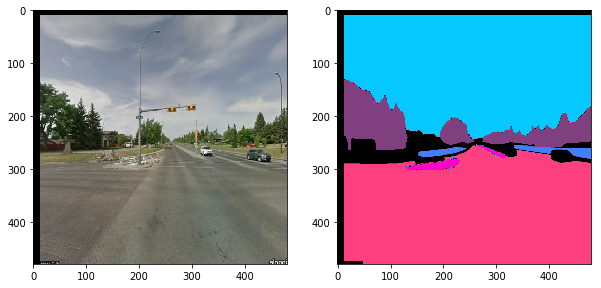

In [11]:
color_map = tf.constant([[0,0,0],[128,64,128],[64,128,256],[255,64,128],[0,150,80],[12,6,128],[4,200,256],[255,5,200]], tf.int32)

data_aug_iter = train_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

batch_of_imgs, label = next_element

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(batch_of_imgs[0])

plt.subplot(1, 2, 2)
label = tf.argmax(label[0], axis=-1)
plt.imshow(tf.nn.embedding_lookup(color_map, label))
plt.show() 

In [12]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [13]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(decoder0)

In [14]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [15]:
class MeanIoU(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def mean_iou(self, y_true, y_pred):
        return tf.py_func(self.np_mean_iou, [y_true, y_pred], tf.float32)

    def np_mean_iou(self, y_true, y_pred):
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive
        false_negative = np.sum(conf, 1) - true_positive

        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        iou[np.isnan(iou)] = 0

        return np.mean(iou).astype(np.float32)

miou_metric = MeanIoU(num_classes)

In [ ]:
model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=[miou_metric.mean_iou])
model.summary()

In [ ]:
save_model_path = 'weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='loss', save_best_only=True, verbose=1,period=10)

In [ ]:
history = model.fit(train_ds,
                   steps_per_epoch=int(np.ceil(num_records_train / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_records_val / float(batch_size))),
                   callbacks=[cp])

In [ ]:
plt.style.use('ggplot')
f, (ax1, ax2) = plt.subplots(1, 2)
plt.tight_layout(pad=1.5,w_pad=0.2)

# Plot training & validation loss values
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
ax1.set_ylabel('Loss')
ax1.set_ylim(top=2)
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation mIOU
ax2.plot(history.history['mean_iou'])
ax2.plot(history.history['val_mean_iou'])
ax2.set_title('Model mIOU')
ax2.set_ylabel('mIOU')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper left')

In [ ]:
f.show()